# Generative Modeling by Estimating Gradients of the Data Distribution
Reference : 

Song Y, Sohl-Dickstein J, Kingma D P, et al. Score-based generative modeling through stochastic differential equations[J]. arXiv preprint arXiv:2011.13456, 2020.

https://yang-song.net/blog/2021/score/



## Score function
The score function of a distribution $p(x)$ is defined as
 $\bigtriangledown_x \log p(x)$, anda model for the score function is called a score-based model, which we denote as $s_\theta(x)$. The score-based model is learned such that 
$s_\theta(x)\approx \bigtriangledown_x \log p(x)$, and can be parameterized without worrying about the normalizing constant.

## Langevin dynamics

Once we have trained a score-based model $s_\theta(x)\approx \bigtriangledown_x\log p(x)$, we can use an iterative procedure called Langevin dynamics.

Langevin dynamics provides an MCMC procedure to sample from a distribution $p(x)$ using only its score function $\bigtriangledown_x\log p(x)$. Specifically, it initializes the chain from an arbitrary prior distribution $x_0 \approx \pi(x)$, and then iterates the following

$x_{i+1}\leftarrow x_i + \epsilon\bigtriangledown_x\log p(x) + \sqrt{2\epsilon}z_i,  i=0,1,...,k$ where $z_i \sim N(0,I)$. When $\epsilon \leftarrow 0$ and $K \leftarrow  \infty$, $x_k$ converges to a sample from $p(x)$.

## Naive score-based generative modeling and its pitfalls
The key challenge is the fact that the estimated score functions are inaccurate in low density regions.

$E_{p(x)}[||\bigtriangledown_x\log p(x) - s_\theta(x)||^2_2] = \int p(x)||\bigtriangledown_x\log p(x) - s_\theta(x)||^2_2dx$

Since the score-based model are weighted by $p(x)$, they are largely ignored in low density regins where $p(x)$ is small.

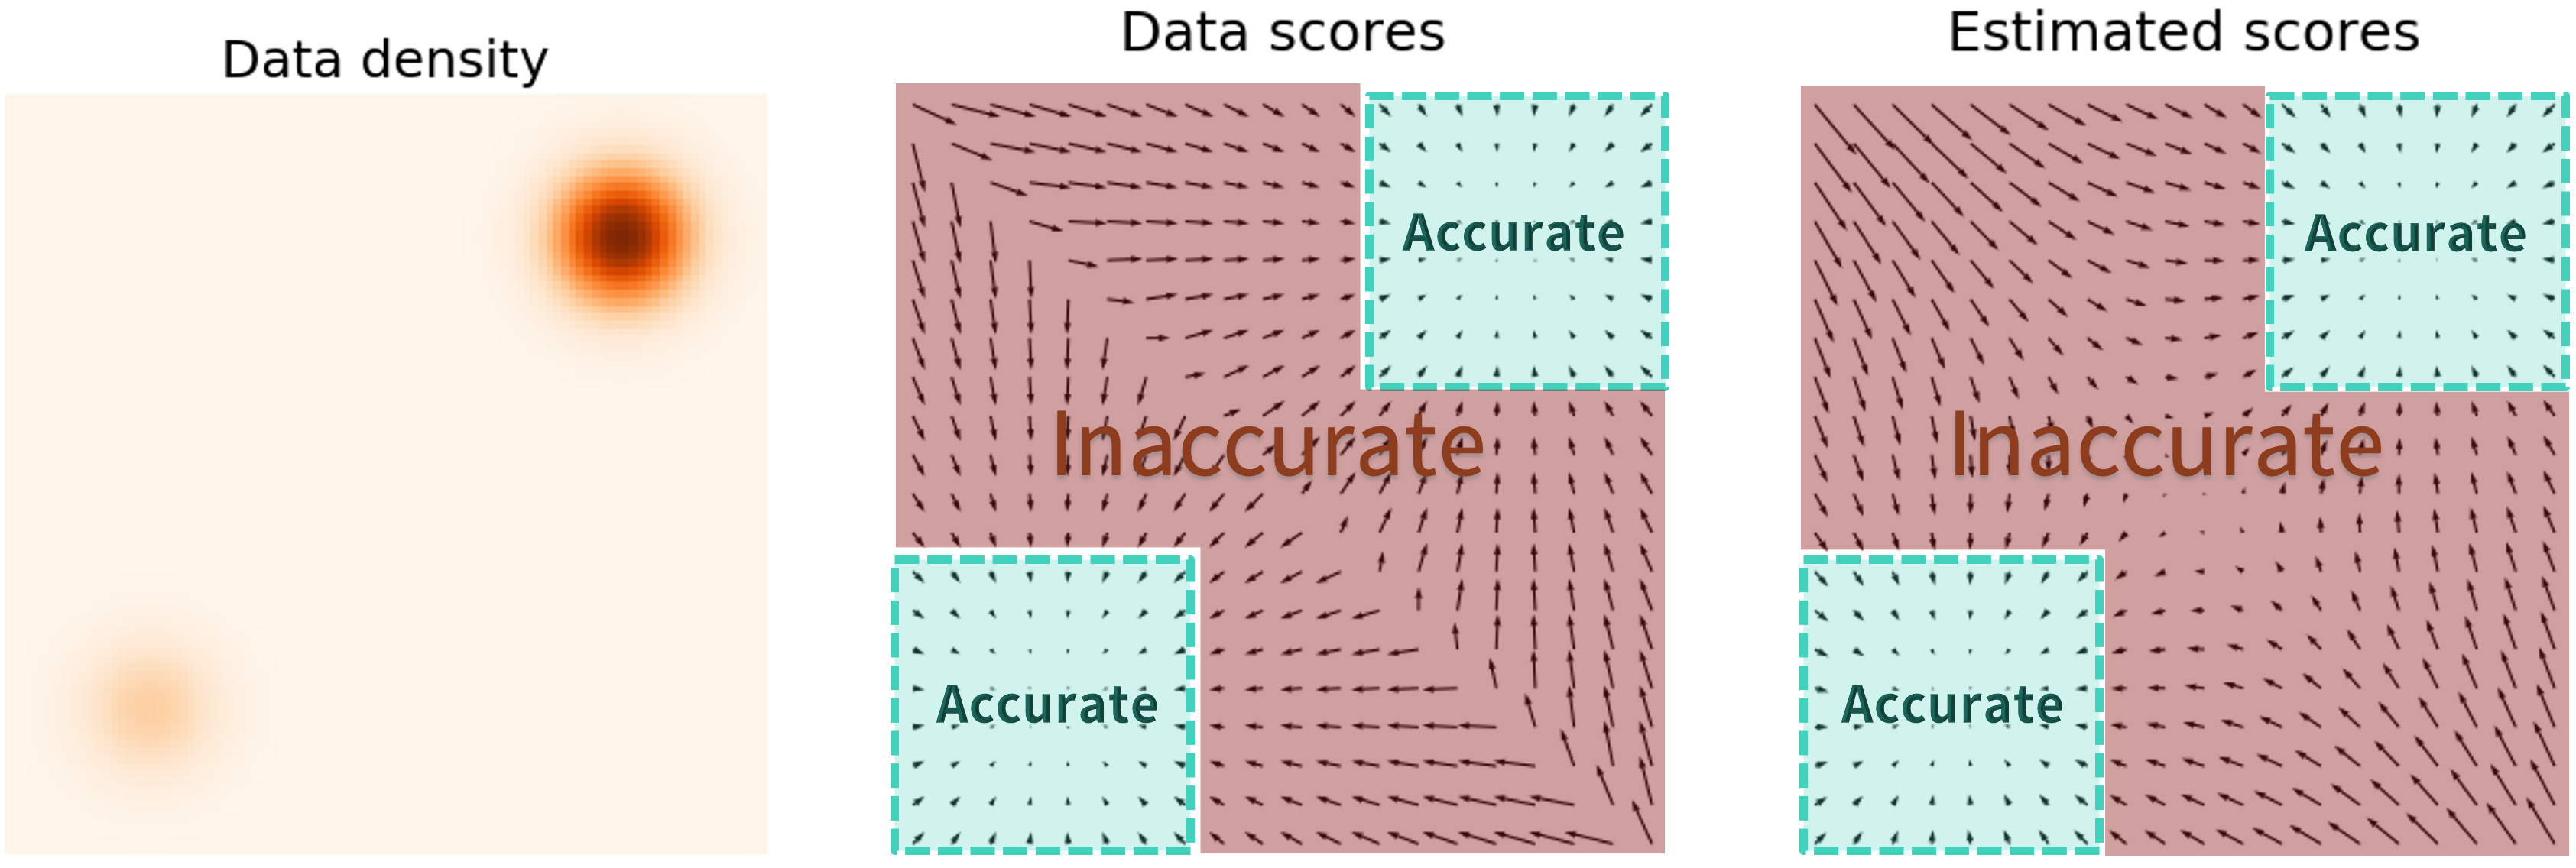

## Score-based generative modeling with multiple noise perturbations

Yang Song's solution is to perturb data points with noise and train score-based models on the noisy data points instead.

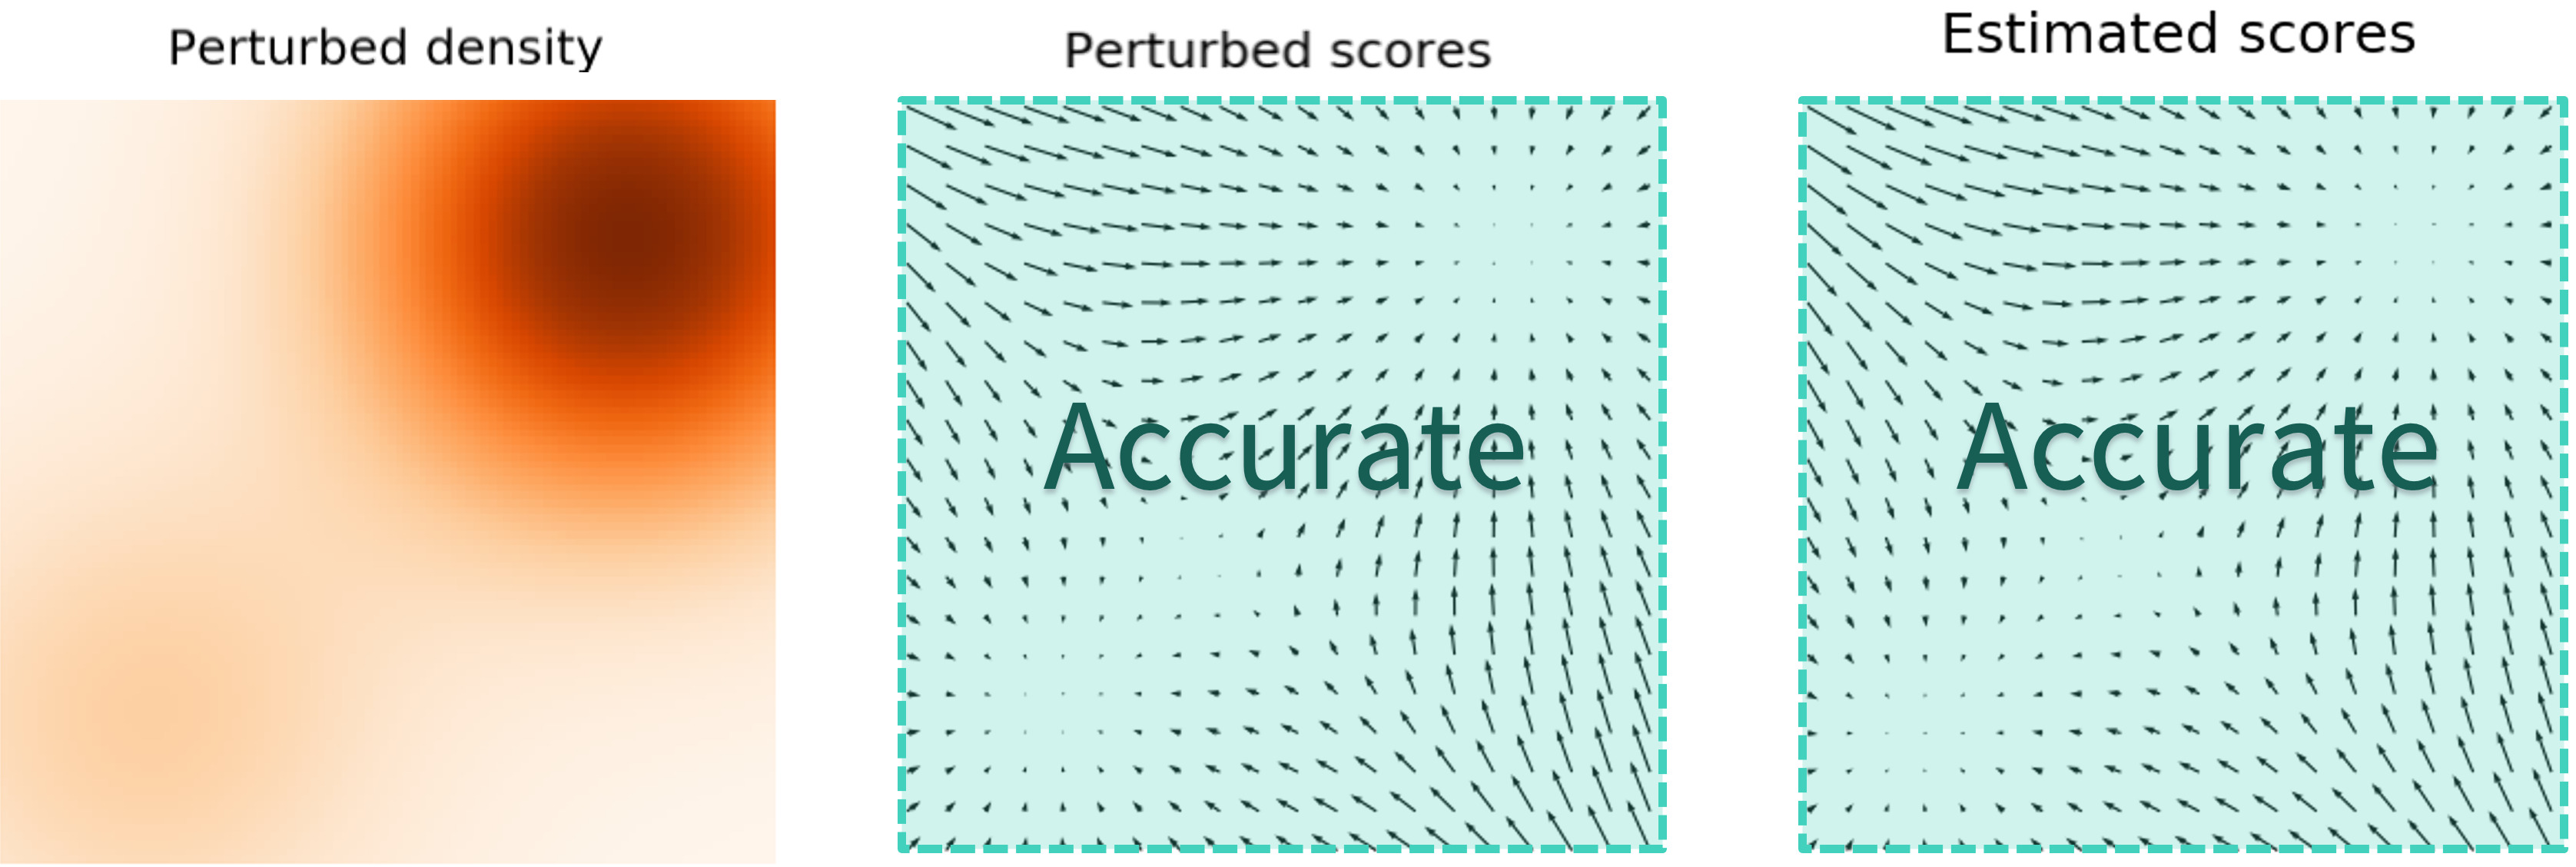

Yet another question remains: how to choose an appropriate noise scale for the perturbation process?

Multiple scales of noise perturbations are used simultaneously. Suppose we always perturb the data with isotropic Gaussian noise, and let there be a total of L increasing standard deviations $\sigma_1,\sigma_2,...,\sigma_L$. We first perturb the data distribution $p(x)$ with each of the Gaussain noise  $N(0,\sigma_i^2 I),i=1,2,...,L$ to obtain a noise-perturbed distribution.

$p_{\sigma_i}(x) = \int p(y)N(x;y,\sigma_i^2I)dy$.

Next we estimate the score function of each noise-perturbed distribution, $\bigtriangledown_x\log p_{\sigma_i}(x)$, by training a Noise Conditional Score-Based Model $s_\theta(x,i)$ with score matching.

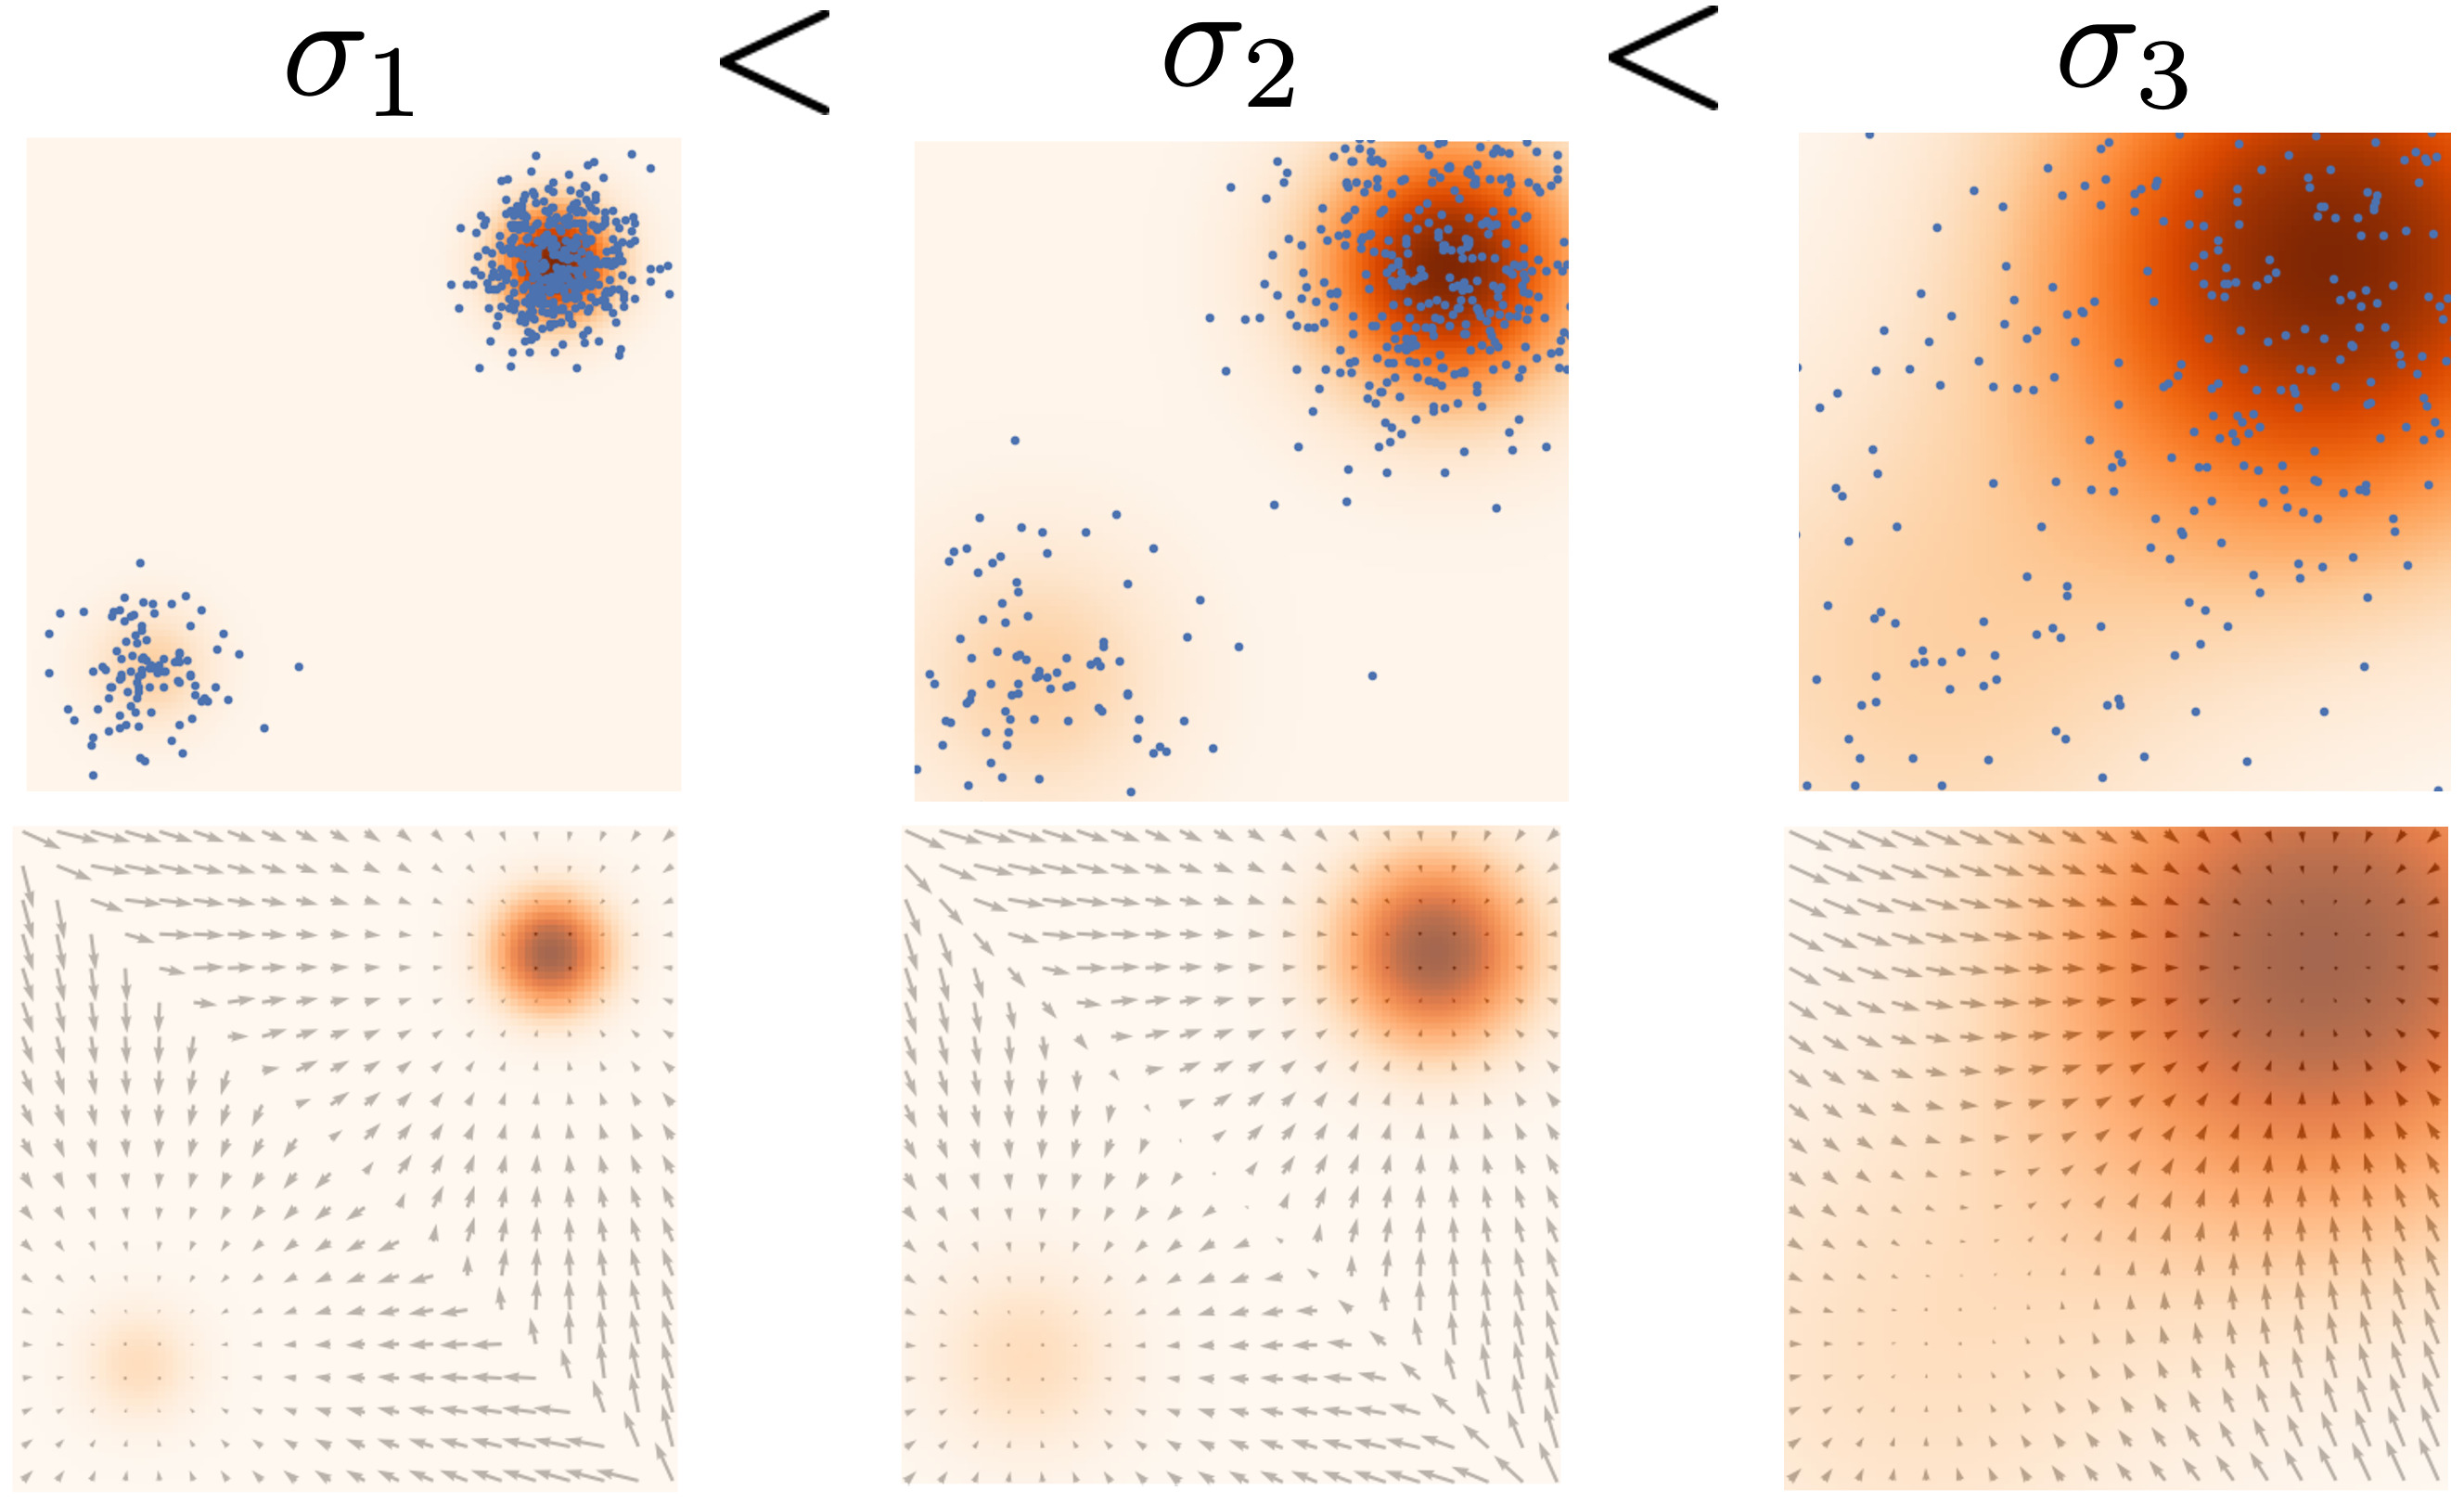

The training objective for $s_\theta(x,i)$ is a weighted sun of Fisher divergence for all noise scales.

$\sum_{i=1}^L\lambda(i)E_{p_{\sigma i}}(x)[||\bigtriangledown_x\log p_{\sigma i}(x) - s_\theta(x,i)||^2_2]$,

where $\lambda(i)$ is a positive weighting function, often chosen to be $\sigma_i^2$.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import functools
from torch.optim import Adam
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
import tqdm
import copy

In [3]:
#@title Defining a time-dependent score-based model

class TimeEncoding(nn.Module):

  def __init__(self, embed_dim, scale=30.):
    super().__init__()
    # Randomly sample weights during initialization. These weights are fixed
    # during optimization and are not trainable.
    self.W = nn.Parameter(torch.randn(embed_dim // 2) * scale, requires_grad=False)
  
  def forward(self, x):
    x_proj = x[:, None] * self.W[None, :] * 2 * np.pi
    return torch.cat([torch.sin(x_proj), torch.cos(x_proj)], dim=-1)

class Dense(nn.Module):
  """A fully connected layer that reshapes outputs to feature maps."""
  def __init__(self, input_dim, output_dim):
    super().__init__()
    self.dense = nn.Linear(input_dim, output_dim)
  
  def forward(self,x):
    return self.dense(x)[..., None, None] # expand two dimensions in the end

class ScoreNet(nn.Module):

  def __init__(self, marginal_prob_std, channels=[32, 64, 128, 256], embed_dim=256):
    """Initial a time-dependent score-based network.
    Args:
    marginal_prob_std: A function that takes time t and gives the standard
     deviation of the perturabtion kernel p_{0t}(x(t) | x(0)).
    channels: The number of channels for feature maps of each solution.
    embed_dim: The dimensionality of Gaussian random feature embeddings.
    """
    super().__init__()
    # Gaussian random feature embedding layer for time
    self.embed = nn.Sequential(TimeEncoding(embed_dim=embed_dim), nn.Linear(embed_dim, embed_dim)) # time embedding

    # Encoder part of U-net
    self.conv1 = nn.Conv2d(1, channels[0], 3, stride=1, bias=False)
    self.dense1 = Dense(embed_dim, channels[0])
    self.gnorm1 = nn.GroupNorm(4, num_channels=channels[0])
    self.conv2 = nn.Conv2d(channels[0], channels[1], 3, stride=2, bias=False)
    self.dense2 = Dense(embed_dim,channels[1])
    self.gnorm2 = nn.GroupNorm(32, num_channels=channels[1])
    self.conv3 = nn.Conv2d(channels[1], channels[2], 3, stride=2, bias=False)
    self.dense3 = Dense(embed_dim, channels[2])
    self.gnorm3 = nn.GroupNorm(32, num_channels=channels[2])
    self.conv4 = nn.Conv2d(channels[2], channels[3], 3, stride=2, bias=False)
    self.dense4 = Dense(embed_dim, channels[3])
    self.gnorm4 = nn.GroupNorm(32, num_channels=channels[3])

    # Decoder part of U-net
    self.tconv4 = nn.ConvTranspose2d(channels[3], channels[2], 3, stride=2, bias=False)
    self.dense5 = Dense(embed_dim, channels[2])
    self.tgnorm4 = nn.GroupNorm(32, num_channels=channels[2])
    self.tconv3 = nn.ConvTranspose2d(channels[2] + channels[2], channels[1], 3, stride=2, bias=False, output_padding=1)
    self.dense6 = Dense(embed_dim, channels[1])
    self.tgnorm3 = nn.GroupNorm(32, num_channels=channels[1])
    self.tconv2 = nn.ConvTranspose2d(channels[1] + channels[1], channels[0], 3, stride=2, bias=False, output_padding=1)
    self.dense7 = Dense(embed_dim, channels[0])
    self.tgnorm2 = nn.GroupNorm(32, num_channels=channels[0])

    # The swish activation f(x) = x*sigmoid(x)
    self.act = lambda x: x * torch.sigmoid(x)

    self.tconv1 = nn.ConvTranspose2d(channels[0] + channels[0], 1, 3, stride=1)
    self.marginal_prob_std = marginal_prob_std
  
  def forward(self, x, t):
    # time embedding
    embed = self.act(self.embed(t))

    # encoder part
    h1 = self.conv1(x)
    h1 += self.dense1(embed)
    h1 = self.gnorm1(h1)
    h1 = self.act(h1)
    h2 = self.conv2(h1)
    h2 += self.dense2(embed)
    h2 = self.gnorm2(h2)
    h2 = self.act(h2)
    h3 = self.conv3(h2)
    h3 += self.dense3(embed)
    h3 = self.gnorm3(h3)
    h3 = self.act(h3)
    h4 = self.conv4(h3)
    h4 += self.dense4(embed)
    h4 = self.gnorm4(h4)
    h4 = self.act(h4)

    # decoder part
    h = self.tconv4(h4)
    h += self.dense5(embed)
    h = self.tgnorm4(h)
    h = self.act(h)
    h = self.tconv3(torch.cat([h,h3], dim=1))
    h += self.dense6(embed)
    h = self.tgnorm3(h)
    h = self.act(h)
    h = self.tconv2(torch.cat([h,h2], dim=1))
    h += self.dense7(embed)
    h = self.tgnorm2(h)
    h = self.act(h)
    h = self.tconv1(torch.cat([h,h1], dim=1))

    # Normalize output
    h = h / self.marginal_prob_std(t)[:, None, None, None] 

    return h

In [4]:
device = 'cuda'

def marginal_prob_std(t, sigma):
  # Calcualte the standard deviation of perturbed Gaussian distribution of time t
  t = torch.tensor(t, device=device)
  return torch.sqrt((sigma**(2*t)-1.)/2./np.log(sigma))

def diffusion_coeff(t, sigma):
  # Calculate the diffusion coefficient of time t
  return torch.tensor(sigma**t, device=device)

sigma = 25.0
marginal_prob_std_fn = functools.partial(marginal_prob_std, sigma=sigma)
diffusion_coeff_fn = functools.partial(diffusion_coeff, sigma=sigma)

In [5]:
def loss_fn(model, x, marginal_prob_std, eps=1e-5):
  """The loss function for training score-based generative models
  Args:
   model: A PyTorch model instance that represents a time-dependent
    score-based model.
   x: A mini-batch of training data.
   marginal_prob_std: A function that gives the standard deviation of 
    the perturbation kernel
   eps: A tolerance value for numerical stability
  """
  # Step1: Randomly generate float t from [0.00001, 0.9999]
  random_t = torch.rand(x.shape[0], device=x.device) * (1.- eps) + eps

  # Step2: Building a distribution p_t(x) based on reparameter
  z = torch.randn_like(x)
  std = marginal_prob_std(random_t)
  perturbed_x = x + z * std[:, None, None, None]

  # Step3: Predict the score by inputing the noised sample and time into score network
  score = score_model(perturbed_x, random_t)

  # Step4: Caculate the score matching loss
  loss = torch.mean(torch.sum((score * std[:, None, None, None] + z)**2, dim=(1,2,3)))
  return loss

In [6]:
class EMA(nn.Module):
  def __init__(self, model, decay=0.9999, device = None):
    super(EMA, self).__init__()
    # Make a copy of the model for accumulating moving average of weights
    self.module = copy.deepcopy(model)
    self.module.eval()
    self.dacay = decay
    self.device = device
    if self.device is not None:
      self.module.to(device=device)
    
  
  def _update(self, model, update_fn):
    with torch.no_grad():
      for ema_v, model_v in zip(self.module.state_dict().values(), model.state_dict().values()):
        if self.device is not None:
          model_v = model_v.to(device = self.device)
          ema_v.copy_(update_fn(ema_v, model_v))
  
  def update(self, model):
    self._update(model, update_fn=lambda e, m: self.decay * e + (1. - self.decay) * m)
  
  def set(self, model):
    self._update(model, update_fn=lambda e, m: m)

In [7]:
#@title Training score-based model on MNIST data

score_model = torch.nn.DataParallel(ScoreNet(marginal_prob_std = marginal_prob_std_fn))
score_model = score_model.to(device)

n_epochs = 50 
## size of a mini-batch
batch_size = 32 
## learning rate
lr = 1e-4 

dataset = MNIST('.', train=True, transform=transforms.ToTensor(), download=True)
data_loader = DataLoader(dataset, batch_size=batch_size, num_workers=4)

optimizer = Adam(score_model.parameters(), lr=lr)
tqdm_epoch = tqdm.tqdm(range(n_epochs))

ema = EMA(score_model)
for epoch in tqdm_epoch:
  avg_loss = 0.
  num_items = 0
  for x, y in data_loader:
    x = x.to(device)
    loss = loss_fn(score_model, x, marginal_prob_std_fn)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    ema.update(score_model)
    avg_loss += loss.item() * x.shape[0]
    num_items += x.shape[0]
  
  print('Average ScoreMatching Loss: {:5f}'.format(avg_loss/num_items))
  torch.save(score_model.state_dict(),'ckpt.pth')

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting .\MNIST\raw\train-images-idx3-ubyte.gz to .\MNIST\raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting .\MNIST\raw\train-labels-idx1-ubyte.gz to .\MNIST\raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting .\MNIST\raw\t10k-images-idx3-ubyte.gz to .\MNIST\raw



  0%|          | 0/4542 [00:00<?, ?it/s]

  0%|                                                                                           | 0/50 [00:00<?, ?it/s]

Extracting .\MNIST\raw\t10k-labels-idx1-ubyte.gz to .\MNIST\raw



<ipython-input-4-609e0675f19f>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t, device=device)
  2%|█▋                                                                                 | 1/50 [00:27<22:06, 27.08s/it]

Average ScoreMatching Loss: 313.376365


  4%|███▎                                                                               | 2/50 [00:48<19:08, 23.92s/it]

Average ScoreMatching Loss: 72.340020


  6%|████▉                                                                              | 3/50 [01:10<17:57, 22.92s/it]

Average ScoreMatching Loss: 46.314960


  8%|██████▋                                                                            | 4/50 [01:32<17:15, 22.52s/it]

Average ScoreMatching Loss: 37.340592


 10%|████████▎                                                                          | 5/50 [01:54<16:47, 22.39s/it]

Average ScoreMatching Loss: 32.091830


 12%|█████████▉                                                                         | 6/50 [02:16<16:23, 22.34s/it]

Average ScoreMatching Loss: 28.400152


 14%|███████████▌                                                                       | 7/50 [02:38<15:56, 22.25s/it]

Average ScoreMatching Loss: 26.479779


 16%|█████████████▎                                                                     | 8/50 [03:00<15:29, 22.13s/it]

Average ScoreMatching Loss: 25.082810


 18%|██████████████▉                                                                    | 9/50 [03:23<15:09, 22.18s/it]

Average ScoreMatching Loss: 23.652152


 20%|████████████████▍                                                                 | 10/50 [03:45<14:51, 22.28s/it]

Average ScoreMatching Loss: 22.952260


 22%|██████████████████                                                                | 11/50 [04:07<14:25, 22.19s/it]

Average ScoreMatching Loss: 22.364023


 24%|███████████████████▋                                                              | 12/50 [04:29<14:00, 22.12s/it]

Average ScoreMatching Loss: 21.550839


 26%|█████████████████████▎                                                            | 13/50 [04:51<13:36, 22.08s/it]

Average ScoreMatching Loss: 21.254024


 28%|██████████████████████▉                                                           | 14/50 [05:13<13:13, 22.05s/it]

Average ScoreMatching Loss: 20.872204


 30%|████████████████████████▌                                                         | 15/50 [05:35<12:49, 21.97s/it]

Average ScoreMatching Loss: 20.476316


 32%|██████████████████████████▏                                                       | 16/50 [05:57<12:26, 21.95s/it]

Average ScoreMatching Loss: 20.341382


 34%|███████████████████████████▉                                                      | 17/50 [06:19<12:08, 22.08s/it]

Average ScoreMatching Loss: 19.957765


 36%|█████████████████████████████▌                                                    | 18/50 [06:41<11:49, 22.17s/it]

Average ScoreMatching Loss: 19.720038


 38%|███████████████████████████████▏                                                  | 19/50 [07:04<11:27, 22.18s/it]

Average ScoreMatching Loss: 19.531799


 40%|████████████████████████████████▊                                                 | 20/50 [07:26<11:07, 22.25s/it]

Average ScoreMatching Loss: 19.153427


 42%|██████████████████████████████████▍                                               | 21/50 [07:48<10:47, 22.31s/it]

Average ScoreMatching Loss: 19.199183


 44%|████████████████████████████████████                                              | 22/50 [08:11<10:25, 22.34s/it]

Average ScoreMatching Loss: 19.014028


 46%|█████████████████████████████████████▋                                            | 23/50 [08:33<09:59, 22.22s/it]

Average ScoreMatching Loss: 18.794200


 48%|███████████████████████████████████████▎                                          | 24/50 [08:55<09:39, 22.29s/it]

Average ScoreMatching Loss: 18.867379


 50%|█████████████████████████████████████████                                         | 25/50 [09:18<09:17, 22.30s/it]

Average ScoreMatching Loss: 18.384478


 52%|██████████████████████████████████████████▋                                       | 26/50 [09:43<09:18, 23.25s/it]

Average ScoreMatching Loss: 18.453196


 54%|████████████████████████████████████████████▎                                     | 27/50 [10:05<08:47, 22.95s/it]

Average ScoreMatching Loss: 18.494921


 56%|█████████████████████████████████████████████▉                                    | 28/50 [10:28<08:21, 22.80s/it]

Average ScoreMatching Loss: 18.180699


 58%|███████████████████████████████████████████████▌                                  | 29/50 [10:50<07:57, 22.73s/it]

Average ScoreMatching Loss: 18.217903


 60%|█████████████████████████████████████████████████▏                                | 30/50 [11:13<07:32, 22.62s/it]

Average ScoreMatching Loss: 18.301039


 62%|██████████████████████████████████████████████████▊                               | 31/50 [11:35<07:06, 22.44s/it]

Average ScoreMatching Loss: 18.192973


 64%|████████████████████████████████████████████████████▍                             | 32/50 [11:57<06:44, 22.46s/it]

Average ScoreMatching Loss: 18.206537


 66%|██████████████████████████████████████████████████████                            | 33/50 [12:20<06:21, 22.45s/it]

Average ScoreMatching Loss: 18.022047


 68%|███████████████████████████████████████████████████████▊                          | 34/50 [12:42<05:59, 22.45s/it]

Average ScoreMatching Loss: 17.950582


 70%|█████████████████████████████████████████████████████████▍                        | 35/50 [13:04<05:34, 22.29s/it]

Average ScoreMatching Loss: 17.585459


 72%|███████████████████████████████████████████████████████████                       | 36/50 [13:26<05:12, 22.34s/it]

Average ScoreMatching Loss: 17.818088


 74%|████████████████████████████████████████████████████████████▋                     | 37/50 [13:49<04:50, 22.35s/it]

Average ScoreMatching Loss: 17.577238


 76%|██████████████████████████████████████████████████████████████▎                   | 38/50 [14:11<04:28, 22.34s/it]

Average ScoreMatching Loss: 17.566312


 78%|███████████████████████████████████████████████████████████████▉                  | 39/50 [14:33<04:04, 22.25s/it]

Average ScoreMatching Loss: 17.602911


 80%|█████████████████████████████████████████████████████████████████▌                | 40/50 [14:56<03:43, 22.30s/it]

Average ScoreMatching Loss: 17.367915


 82%|███████████████████████████████████████████████████████████████████▏              | 41/50 [15:18<03:21, 22.37s/it]

Average ScoreMatching Loss: 17.384447


 84%|████████████████████████████████████████████████████████████████████▉             | 42/50 [15:41<02:59, 22.44s/it]

Average ScoreMatching Loss: 17.394782


 86%|██████████████████████████████████████████████████████████████████████▌           | 43/50 [16:03<02:36, 22.32s/it]

Average ScoreMatching Loss: 17.344575


 88%|████████████████████████████████████████████████████████████████████████▏         | 44/50 [16:25<02:14, 22.37s/it]

Average ScoreMatching Loss: 17.280950


 90%|█████████████████████████████████████████████████████████████████████████▊        | 45/50 [16:48<01:51, 22.33s/it]

Average ScoreMatching Loss: 17.394220


 92%|███████████████████████████████████████████████████████████████████████████▍      | 46/50 [17:09<01:28, 22.23s/it]

Average ScoreMatching Loss: 17.348066


 94%|█████████████████████████████████████████████████████████████████████████████     | 47/50 [17:31<01:06, 22.11s/it]

Average ScoreMatching Loss: 17.146449


 96%|██████████████████████████████████████████████████████████████████████████████▋   | 48/50 [17:54<00:44, 22.17s/it]

Average ScoreMatching Loss: 17.326122


 98%|████████████████████████████████████████████████████████████████████████████████▎ | 49/50 [18:16<00:22, 22.13s/it]

Average ScoreMatching Loss: 17.109794


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [18:38<00:00, 22.36s/it]

Average ScoreMatching Loss: 17.100440


# Define the SDE and Denoising Score Matching Objectives

SDE is hand-designed.

First of all, we need to specify an SDE that perturbs the data distribution $p_0$ to a prior distribution $p_T$. We choose the following SDE.

$dx = σ^{t}dw$, $t\in[0,1]$

In this case,

$p_{0t}(x(t)|x(0))=N(x(t),x(0),\frac{1}{2\logσ}(σ^{2t}-1)I)$

and we can choose the weighting function $λ(t)=variance=\frac{1}{2\logσ}(σ^{2t}-1)$.

When $\sigma$ is large, the prior distribution, $p_{t=1}$ is

$\int p_{0}(y)N(x;y,\frac{1}{2\logσ}(σ^{2}-1)I)dy ≈ N(x;0,\frac{1}{2\logσ}(σ^{2}-1)I)$,

which is approximately independent of the data distribution and is easy to sample from.

Intuitively, this SDE captures a continuum of Gaussian perturbations with variance function $\frac{1}{2\logσ}(σ^{2t}-1)$. This continuum of perturbations allows us to gradually transfer samples from a data distribution $p_0$ to a sample Gaussain distribution $p_1$.

In [8]:
## The number of sampling steps.
num_steps = 500
def euler_sampler(score_model, marginal_prob_std, diffusion_coeff, batch_size=64, num_steps = num_steps, device='cuda', eps=1e-3):
  # Step1: Initialize prior distribution
  t = torch.ones(batch_size, device = device)
  init_x = torch.randn(batch_size, 1, 28, 28, device=device) * marginal_prob_std(t)[:, None, None, None]
  # Step2: Define the sampling t and the time step
  time_steps = torch.linspace(1., eps, num_steps, device=device)
  step_size = time_steps[0] - time_steps[1]

  # Steps3: Calculate SDE
  x = init_x
  with torch.no_grad():
    for time_step in tqdm.tqdm(time_steps):
      batch_time_step = torch.ones(batch_size, device=device) * time_step
      g = diffusion_coeff(batch_time_step)
      mean_x = x + (g**2)[:, None, None, None] * score_model(x, batch_time_step) * step_size
      x = mean_x + torch.sqrt(step_size) * g[:, None, None, None] * torch.randn_like(x)
  
  #Step4: Take the epection of the final step as the sample
  return mean_x

In [9]:
signal_to_noise_ratio = 0.16
num_steps = 500
def pc_sampler(score_model, marginal_prob_std, diffusion_coeff, batch_size=64, num_steps=num_steps,snr=signal_to_noise_ratio,  device='cuda', eps=1e-3):
  """ Generate samplers from score-based models with Predictor-Corrector method

  Args:
   score_model: A PyTorch model instance that represents a time-dependent
    score-based model.
   marginal_prob_std: A function that gives the standard deviation of 
    the perturbation kernel.
   diffusion_coeff: A function that gives the diffusion coefficient
    of the SDE.
   batch_size: The number of samplers to generate by calling this function 
    once.
   num_steps: The numer of sampling of discretized time steps.
   device: 'cuda' for running on GPUs, and 'cpu' for running on CPUs.
   eps: A tolerance value for numerical stability. 
  
  Returns:
   Samples.
  """
  # Step1: Initialize the prior distribution samples
  t = torch.ones(batch_size, device = device)
  init_x = torch.randn(batch_size, 1, 28, 28, device=device) * marginal_prob_std(t)[:, None, None, None]

  # Step2: Define the sampling t and the time step
  time_steps = torch.linspace(1., eps, num_steps)
  step_size = time_steps[0] - time_steps[1]

  # Step3: Langevin sampling
  x = init_x
  with torch.no_grad():
    for time_step in tqdm.tqdm(time_steps):
      batch_time_step = torch.ones(batch_size, device=device) * time_step

      grad = score_model(x, batch_time_step)
      grad_norm = torch.norm(grad.reshape(grad.shape[0],-1),dim=-1).mean()
      noise_norm = np.sqrt(np.prod(x.shape[1:]))
      langevin_step_size = 2*(snr * noise_norm / grad_norm)**2
     
      for _ in range(20):
        x = x + langevin_step_size * grad + torch.sqrt(2*langevin_step_size) * torch.randn_like(x)
        grad = score_model(x, batch_time_step)
        grad_norm = torch.norm(grad.reshape(grad.shape[0],-1),dim=-1).mean()
        noise_norm = np.sqrt(np.prod(x.shape[1:]))
        langevin_step_size = 2*(snr * noise_norm / grad_norm)**2
      


    # Predict step (Euler-Maruyama)
    g = diffusion_coeff(batch_time_step)
    x_mean = x + (g**2)[:, None, None, None] * score_model(x, batch_time_step) * step_size
    x = x_mean + torch.sqrt(g**2 * step_size)[:, None, None, None] * torch.randn_like(x)
  
  return x_mean

In [10]:
from scipy import integrate

## The error tolerance for the black-box ODE solver
error_tolerance = 1e-5 
def ode_sampler(score_model, marginal_prob_std, diffusion_coeff, batch_size=64, atol=error_tolerance, rtol=error_tolerance, device='cuda', z=None, eps=1e-3):
  t = torch.ones(batch_size, device=device)
  if z is None:
    init_x = torch.randn(batch_size, 1, 28, 28, device=device) * marginal_prob_std(t)[:, None, None, None]
  else:
    init_x = z
  
  shape = init_x.shape

  # Step2: Define score predicting function
  def score_eval_wrapper(sample, time_steps):
    """A warpper of the score-based model for use by the ODE soler"""
    sample = torch.tensor(sample, device=device, dtype=torch.float32).reshape(shape)
    time_steps = torch.tensor(time_steps, device=device, dtype=torch.float32).reshape((sample.shape[0], ))
    with torch.no_grad():
      score = score_model(sample,time_steps)
    return score.cpu().numpy().reshape((-1,)).astype(np.float64)

  def ode_func(t, x):
    """The ODE function for use by the ODE solver."""
    time_steps = np.ones((shape[0],)) * t
    g = diffusion_coeff(torch.tensor(t)).cpu().numpy()
    return -0.5 * (g**2) * score_eval_wrapper(x, time_steps)
  
  res = integrate.solve_ivp(ode_func, (1., eps), init_x.reshape(-1).cpu().numpy(), rtol=rtol, atol=atol, method='RK45')
  print(f"Number of function evaluations: {res.nfev}")

  x = torch.tensor(res.y[:,-1],device = device).reshape(shape)
  return x
                                                        
                                                  


<ipython-input-4-609e0675f19f>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t, device=device)
100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:59<00:00,  8.40it/s]
<ipython-input-4-609e0675f19f>:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(sigma**t, device=device)


<function pc_sampler at 0x000001A704E860D0> takes 59.53829836845398s


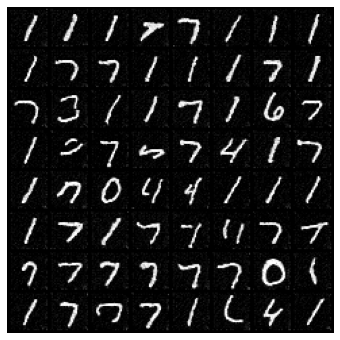

In [11]:
from torchvision.utils import make_grid
import time

## Load the pre-trained checkpoint from disk.
device = 'cuda'
ckpt = torch.load('ckpt.pth', map_location=device)
score_model.load_state_dict(ckpt)

sample_batch_size = 64
sampler = pc_sampler # One of {'euler_sampler', 'pc_sampler', 'ode_sampler'}

t1 = time.time()
## Generate samples using the specified sampler
samples = sampler(score_model, marginal_prob_std_fn, diffusion_coeff_fn, sample_batch_size, device=device)
t2 = time.time()
print(f'{str(sampler)} takes {t2-t1}s')

## Sample visualization.
samples = samples.clamp(0.0, 1.0)
%matplotlib inline
import matplotlib.pyplot as plt 
sample_grid = make_grid(samples, nrow= int(np.sqrt(sample_batch_size)))
plt.figure(figsize=(6,6))
plt.axis('off')
plt.imshow(sample_grid.permute(1, 2, 0).cpu(), vmin=0., vmax=1.)
plt.show()